In [1]:
import functools
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 12)

sns.set()

In [3]:
df_train = pd.read_csv('train.csv', sep="," , encoding="UTF8" )
df_test = pd.read_csv('test.csv', sep="," , encoding="UTF8" )

In [4]:
df_train.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [5]:
df_test.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,...,40.0,420.0,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,...,100.0,580.0,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,...,80.0,320.0,E,E,D,B,B,A,NaN,A
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,...,NaN,NaN,H,E,G,B,B,A,NaN,A
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,...,0.0,320.0,D,H,H,C,B,A,NaN,A


In [6]:
print('Número de observações:', df_train.shape[0],'Número de colunas:', df_train.shape[1])

Número de observações: 13730 Número de colunas: 167


In [7]:
print('Número de observações:', df_test.shape[0],'Número de colunas:', df_test.shape[1])

Número de observações: 4576 Número de colunas: 47


In [8]:
colunas_de_notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
dados_notas = df_train[colunas_de_notas]
dados_notas

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
0,436.3,495.4,581.2,399.4,520.0
1,474.5,544.1,599.0,459.8,580.0
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
13725,438.2,419.7,394.5,403.2,440.0
13726,423.8,557.9,533.0,452.4,560.0
13727,460.5,528.9,569.3,398.0,600.0
13728,422.5,621.7,569.0,386.6,460.0


Em 2016:
Um dia os estudantes fizeram as provas de ciências humanas(CH) e ciências da natureza(CN). No outro dia, a prova de linguagens, códigos e suas tecnologias(LC), matemática(MT) e redação.

In [9]:
faltou = 0
presente = 1
eliminado = 2

In [10]:
dados_notas.isna().sum()

NU_NOTA_CN         3389
NU_NOTA_CH         3389
NU_NOTA_LC         3597
NU_NOTA_MT         3597
NU_NOTA_REDACAO    3597
dtype: int64

In [11]:
faltou = 0
presente = 1
eliminado = 2

dados_notas_filled = dados_notas.copy()

dados_notas_filled.loc[df_train['TP_PRESENCA_CN'].isin([faltou, eliminado]), 'NU_NOTA_CN'] = 0 
dados_notas_filled.loc[df_train['TP_PRESENCA_CH'].isin([faltou, eliminado]), 'NU_NOTA_CH'] = 0
dados_notas_filled.loc[df_train['TP_PRESENCA_LC'].isin([faltou, eliminado]), 'NU_NOTA_LC'] = 0
dados_notas_filled.loc[df_train['TP_PRESENCA_MT'].isin([faltou, eliminado]), 'NU_NOTA_MT'] = 0
dados_notas_filled.loc[df_train['TP_STATUS_REDACAO'].isin([2,3,4,5,6,7,8,9]),'NU_NOTA_REDACAO'] = 0 # 1 = sem problemas (todos os outros valores representam motivos para zerar)
dados_notas_filled.loc[df_train['TP_PRESENCA_LC'].isin([faltou, eliminado]),'NU_NOTA_REDACAO'] = 0 # se a pessoa não foi nas outras duas provas do mesmo dia (LC e MT)


In [12]:
dados_notas_filled.isna().sum()

NU_NOTA_CN         0
NU_NOTA_CH         0
NU_NOTA_LC         0
NU_NOTA_MT         0
NU_NOTA_REDACAO    0
dtype: int64

In [13]:
df_test[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']].isna().sum()

NU_NOTA_CN         1134
NU_NOTA_CH         1134
NU_NOTA_LC         1199
NU_NOTA_REDACAO    1199
dtype: int64

In [14]:
dados_notas_test = df_test[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']]
dados_notas_test

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO
0,464.8,443.5,431.8,420.0
1,391.1,491.1,548.0,580.0
2,595.9,622.7,613.6,320.0
3,NaN,NaN,NaN,NaN
4,592.9,492.6,571.4,320.0
...,...,...,...,...
4571,398.3,558.2,511.6,500.0
4572,427.6,579.7,471.1,520.0
4573,639.2,643.8,604.9,640.0
4574,427.1,467.9,540.2,520.0


In [15]:
dados_notas_test_filled = dados_notas_test.copy()

dados_notas_test_filled.loc[df_test['TP_PRESENCA_CN'].isin([faltou, eliminado]), 'NU_NOTA_CN'] = 0 
dados_notas_test_filled.loc[df_test['TP_PRESENCA_CH'].isin([faltou, eliminado]), 'NU_NOTA_CH'] = 0
dados_notas_test_filled.loc[df_test['TP_PRESENCA_LC'].isin([faltou, eliminado]), 'NU_NOTA_LC'] = 0
dados_notas_test_filled.loc[df_test['TP_STATUS_REDACAO'].isin([2,3,4,5,6,7,8,9]),'NU_NOTA_REDACAO'] = 0 # 1 = sem problemas (todos os outros valores representam motivos para zerar)
dados_notas_test_filled.loc[df_test['TP_PRESENCA_LC'].isin([faltou, eliminado]),'NU_NOTA_REDACAO'] = 0 # se a pessoa não foi nas outras duas provas do mesmo dia (LC e MT)


In [17]:
dados_notas_test_filled.isna().sum()

NU_NOTA_CN         0
NU_NOTA_CH         0
NU_NOTA_LC         0
NU_NOTA_REDACAO    0
dtype: int64

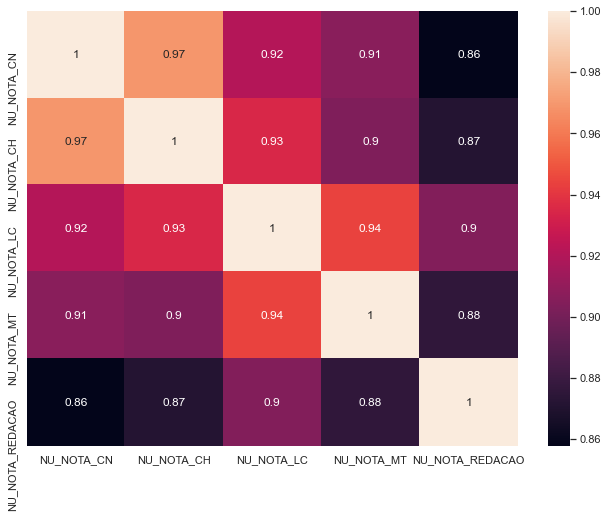

In [18]:
corr = dados_notas_filled.corr()
ax = plt.subplots(figsize=(11, 8))
sns.heatmap(corr,  annot=True)

In [19]:
colunas_features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']

In [20]:
x_train = dados_notas_filled[colunas_features]
y_train = dados_notas_filled['NU_NOTA_MT']
x_test = dados_notas_test_filled[colunas_features]

Usando Regressão Linear

In [21]:
linear_regression = LinearRegression()

linear_regression.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
predicted = linear_regression.predict(x_test)
predicted

array([424.37827087, 482.47408063, 560.13079912, ..., 592.76183803,
       488.03166117,  -2.81752868])

In [34]:
answer = pd.DataFrame({'NU_INSCRICAO': df_test['NU_INSCRICAO'], 'NU_NOTA_MT': predicted})
answer.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,424.378271
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,482.474081
2,b38a03232f43b11c9d0788abaf060f7366053b6d,560.130799
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,-2.817529
4,715494628a50142ce8cb17191cfe6d0f3cae0934,547.612944


In [35]:
answer.to_csv('answer.csv')